# Génération automatique de textes neuronale avec une architecture encodeur/décodeur

Dans ce TP du cours `Génération automatique de textes`, on s'intéresse à une tâche de génération de textes à partir de représentations sémantiques. Nous nous intéresserons au corpus [WebNLG](https://synalp.gitlabpages.inria.fr/webnlg-challenge/challenge_2020/) qui a été mis en place pour un défi de génération à partir de données issues du _web sémantique_.


Nous aborderons la tâche de génération comme une tâche de traduction de "data" vers "text". Le système de génération sera réalisé par apprentissage automatique d'un modèle encodeur/décodeur.

# Introduction

## Génération _data-to-text_

Les systèmes de génération de textes ont généralement des entrées non linguistiques. Les entrées les plus fréquentes sont les tableaux et les bases de connaissances.


Par exemple, la GAT est souvent appliquée pour la prévision météorologique à partir de tableaux de valeurs prédites. On trouve également des systèmes résumant des  rencontres sportives à partir, par exemple, de tableaux de synthèse de résultats de matchs de basket-ball.


Il existe également un fort intérêt pour la génération à partir de base de connaissances. On peut, par exemple, chercher à générer des comptes rendus à partir de données cliniques structurées ou à synthétiser des descriptions à partir de données DBPedia encodées en RDF.

L'exemple ci-dessous est extrait du défi [WebNLG](https://synalp.gitlabpages.inria.fr/webnlg-challenge/challenge_2020/). Dans la partie **(a)**, l'entreprise `Trane` est de type `Company` est décrite par un ensemble de triplets `Entité | relation | Entité/valeur` (appelés respectivement *sujet*, *prédicat* et *objet*). On voit ainsi que Trane a 29000 employés. La partie **(b)** montre un texte de référence qui décrit l'ensemble des triplets. Le but de la tâche est d'apprendre un modèle capable de générer une description textuelle d'un ensemble de triplets RDF qui est le langage de représentation du web sémantique (par exemple, Wikipedia).  


<ul>
<div class="admonition example">
<p><strong>(a) Set of RDF triples</strong>
</p><div class="highlight"><pre id="__code_1"><span></span><code><span class="nt">&lt;entry</span> <span class="na">category=</span><span class="s">"Company"</span> <span class="na">eid=</span><span class="s">"Id21"</span> <span class="na">shape=</span><span class="s">"(X (X) (X) (X) (X))"</span> <span class="na">shape_type=</span><span class="s">"sibling"</span> <span class="na">size=</span><span class="s">"4"</span><span class="nt">&gt;</span>
    <span class="nt">&lt;modifiedtripleset&gt;</span>
        <span class="nt">&lt;mtriple&gt;</span>Trane | foundingDate | 1913-01-01<span class="nt">&lt;/mtriple&gt;</span>
        <span class="nt">&lt;mtriple&gt;</span>Trane | location | Ireland<span class="nt">&lt;/mtriple&gt;</span>
        <span class="nt">&lt;mtriple&gt;</span>Trane | foundationPlace | La_Crosse,_Wisconsin<span class="nt">&lt;/mtriple&gt;</span>
        <span class="nt">&lt;mtriple&gt;</span>Trane | numberOfEmployees | 29000<span class="nt">&lt;/mtriple&gt;</span>
    <span class="nt">&lt;/modifiedtripleset&gt;</span>
<span class="nt">&lt;/entry&gt;</span>
</code></pre></div><p></p>
<p><strong>(b) English text</strong></p>
<p><em>Trane, which was founded on January 1<sup>st</sup> 1913 in La Crosse, Wisconsin, is based in Ireland. It has 29,000 employees.</em></p>
</div>
</ul>

# Corpus


Le [Challenge WebNLG](https://synalp.gitlabpages.inria.fr/webnlg-challenge/challenge_2017/) consiste à générer des descriptions de triplets RDF. Les données d'entraînement consistent en des paires données/texte où les données sont un ensemble de triplets extraits de DBpedia et le texte est une verbalisation de ces triplets.

Par exemple, étant donné les trois triplets de DBpedia [a], l'objectif est de générer le texte [b] :

> [a].
- `(Abilene,_Texas | isPartOf | Jones_County,_Texas)`
- `(Abilene,_Texas | country | United_States)`
- `(United_States | language | English_language)`

> [b]. *Abilene is part of Jones County, Texas in the United States and English is the language of the United States.*


> Le jeu de données `WebNLG challenge` se compose de 21 855 paires données/texte avec un total de 8 372 données distinctes en entrée. Les données d'entrée décrivent des entités appartenant à neuf catégories DBpedia distinctes, à savoir : _astronaute_, _université_, _monument_, _bâtiment_, _personnage de bande dessinée_, _nourriture_, _aéroport_, _équipe sportive_ et _littérature_. De nouvelles versions du jeu de données ont été diffusées depuis, contenant entre autres de nouvelles catégories DBpedia comme _corps céleste_, _transport_, _ville_, _athlète_, _personnage politique_, _artiste_.


## Questions

Les differentes version de WebNLG sont accessible à partir de ce [dépôt Git](https://gitlab.com/shimorina/webnlg-dataset). En observant la version 3.0 répondez aux questions suivantes :

1. Observez le corpus, quel type de données sont utilisées en entrées du système ?   triplets RDF (Resource Description Framework)

2. Observez les différents répertoires `dev/test/train` dans `release_v3.0/en`, quelles sont les caractéristiques des données présentes ?  XML organisés par catégories

(Par exemple, différents triplets, catégories, `originaltripleset` vs. `modifiedtripleset` et les phrases de référence.)

# Prétraitement du corpus

## Installation des paquets nécessaires

Nous allons devoir utiliser un certain nombre de bilbiothèques. Exécutez le code ci-dessous pour les installer.

In [ ]:
# Pour télécharger les trois fichiers `py` (`nmt_dataset.py`, `nnet_models.py` et `prepare.py`)
!git clone https://github.com/yongxin2020/TP_ML_IDL/
!mv TP_ML_IDL/NMT/pyfiles/* .
!rm -r TP_ML_IDL

!pip install torch

!pip install subword_nmt
!pip install sacremoses # MosesTokenizer en Python
!pip install pandas # Pour la lecture de données
!pip install sacrebleu # Pour le calcul des scores BLEU
!pip install matplotlib # Graphiques et animations

Cloning into 'TP_ML_IDL'...
remote: Enumerating objects: 34113, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 34113 (delta 14), reused 37 (delta 7), pack-reused 34057 (from 1)
Receiving objects: 100% (34113/34113), 52.50 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (35895/35895), done.


Par ailleurs, pour tous le reste du TP nous aurons besoin des imports python suivants.

In [ ]:
import zipfile
import urllib.request
import glob
import os
import re
import sys
import xml.etree.ElementTree as ET
import pandas as pd
from sacremoses import MosesTokenizer
import nmt_dataset
import nnet_models
import numpy as np
import torch
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from subword_nmt.apply_bpe import BPE

%matplotlib inline

## Téléchargement des données et partitionnement

In [ ]:
# Données officielles de WebNLG 2020, version 3.0
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
  zip_ref.extractall('web')

**NOTE IMPORTANT** :

Pour réduire le temps d'entraînement, nous allons seulement utiliser les données de la catégorie **`City`** du repertoire **`3triples`** au lieu de l'ensemble du corpus. Vous pourrez considérer plus exemples d'apprentissage au cours de ce TP.

In [ ]:
"""
Fonction de pré-traitement du texte : lit "input_text" et "target_text",
utilise "prefix" pour le trainset et le devset
et garde les triplets normaux tels quels, mais unit les triplets multiples avec "&&"
"""

def process_data(prefix):
    md = MosesTokenizer(lang='en')
    # Étant donné les ressources de calcul limitées dont nous disposons,
    # on commence en utilisant saulement la catégorie "City". Plus tard, vous
    # pourrez essayer "/3triples/*.xml" pour toutes les séries de trois triplets
    # et "/**/*.xml" pour toutes les données
    files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-/release_v3.0/en/" + \
                      prefix + "/?triples/City.xml", recursive=True)


    triple_re = re.compile('(\d)triples')
    data_dct = {}
    for file in files:
        tree = ET.parse(file)
        root = tree.getroot()
        triples_num=int(triple_re.findall(file)[0])
        for sub_root in root:
            for ss_root in sub_root:
                strutured_master = []
                unstructured = []
                for entry in ss_root:
                    unstructured.append(entry.text)
                    strutured = [triple.text for triple in entry]
                    strutured_master.extend(strutured)
                unstructured = [i for i in unstructured if i.replace('\n','').strip()!='' ]
                strutured_master = strutured_master[-triples_num:]
                strutured_master_str = (' && ').join(strutured_master)
                data_dct[strutured_master_str] = unstructured

    mdata_dct = {"source_text":[], "target_text":[]}
    for st, unst in data_dct.items():
        for i in unst:
            mdata_dct['source_text'].append(st)
            mdata_dct['target_text'].append(md.tokenize(i,return_str=True))
    df = pd.DataFrame(mdata_dct)
    df.to_csv('data/webNLG2020.' + prefix + '.csv')
    with open('data/webNLG2020.' + prefix + '_src.txt', "w") as file:
        file.write( "\n".join(mdata_dct['source_text']))
    with open('data/webNLG2020.' + prefix + '_tgt.txt', "w") as file:
        file.write( "\n".join(mdata_dct['target_text']))

In [ ]:
# Création du répertoire de données et chargement des partitions de données
!mkdir -p data

for u in ['train', 'dev']:
    process_data(u)

In [ ]:
train_df = pd.read_csv('data/webNLG2020.train.csv')
dev_df = pd.read_csv('data/webNLG2020.dev.csv')

print("Nombre d'exemples des partitions train et dev :")
print(len(train_df))
print(len(dev_df))

print("Vocabulaire de la source et de la cible de la partition train :")

!cat data/webNLG2020.train_src.txt | tr ' ' '\n' | tr '[:upper:]' '[:lower:]' | sort | uniq | wc -l
!cat data/webNLG2020.train_tgt.txt | tr ' ' '\n' | tr '[:upper:]' '[:lower:]' | sort | uniq | wc -l

Nombre d'exemples des partitions train et dev :
2415
295
Vocabulaire de la source et de la cible de la partition train :
261
623



### Questions
1. Donnez le nombre d'exemples utilisés pour l'apprentissage du modèle et pour sa validation (partition dev).
Nombre d'exemples des partitions train : 2415
et dev : 295
2. Qu'appelle-t-on source et target (cf. ci-dessous) ?
Source désigne la séquence d'entrée du modèle. Dans ce cas précis, il s'agit des données structurées représentées par des triplets RDF (ex: "Atlanta | isPartOf | Georgia_(U.S._state)").
Target désigne la séquence de sortie souhaitée, qui est le texte en langage naturel qui verbalise les triplets d'entrée (ex: "Atlanta is part of Georgia, US.").

3. Est-ce que la taille du vocabulaire justifierait que l'on segmente les séquences d'entrée en sous-mot ?  
Oui, on utilise le BPE pour segmenter les mots en sous-unités fréquentes, ce qui réduit la taille du vocabulaire et permet de gérer les mots hors vocabulaire en les combinant à partir de sous-unités connues, améliorant ainsi la performance et la généralisation du modèle.


In [ ]:
# Affiche les données puis les mélange
print(train_df)
print(dev_df)

print("---------------")

train_df=train_df.sample(frac=1)  # Renvoie un échantillon aléatoire d'objets d'un tableau pandas
dev_df=dev_df.sample(frac=1)
print(train_df)
print(dev_df)

      Unnamed: 0                                        source_text  \
0              0  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
1              1  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
2              2  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
3              3  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
4              4  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
...          ...                                                ...   
2410        2410  United_States_House_of_Representatives | isPar...   
2411        2411  United_States_House_of_Representatives | isPar...   
2412        2412  Williamson_County,_Texas | largestCity | Round...   
2413        2413  Williamson_County,_Texas | largestCity | Round...   
2414        2414  Williamson_County,_Texas | largestCity | Round...   

                                            target_text  
0     Abilene is part of Jones County , Texas in the...  
1     Abilene is part of Jones 

###Questions
1. Quel est l'objectif du code ci-dessous ?
L'objectif est d'entraîner un modèle BPE (Byte Pair Encoding) sur les données source et cible afin de segmenter le texte en sous-mots.
2. Résumez le résultat de l'application de ce code
Le résultat est un modèle BPE avec un vocabulaire de 4000 sous-mots et 1781 paires de sous-unités de mots.
4. Quelles sont les fréquences du mot `the` et `Americans` (la majuscule est importante) ? Vous semblent-elles cohérentes avec un texte en langage naturel ?   
Les fréquences de "the" (élevée) et "Americans" (plus faible) sont cohérentes avec un texte en langage naturel, "the" étant un mot grammatical courant et "Americans" un nom propre plus spécifique.

4. L'utilisation de ces bpe aurait-il pour effet de diminuer la taille du vocabulaire ?
Oui, l'utilisation de BPE réduit la taille du vocabulaire en représentant les mots comme des séquences de sous-mots, diminuant le nombre d'éléments uniques.


In [ ]:
%%shell

# Entraîne un modèle BPE à partir des deux ensembles de données (source et target)
cat data/webNLG2020.train_{tgt,src}.txt | subword-nmt learn-bpe -o data/bpecodes.webnlg -s 4000 -v

  0% 0/4000 [00:00<?, ?it/s]pair 0: t e -> te (frequency 13621)
pair 1: a n -> an (frequency 10931)
pair 2: t a -> ta (frequency 9816)
pair 3: n i -> ni (frequency 9280)
pair 4: a r -> ar (frequency 8566)
pair 5: o u -> ou (frequency 8215)
pair 6: , _ -> ,_ (frequency 7918)
pair 7: n t -> nt (frequency 6462)
pair 8: t h -> th (frequency 6432)
pair 9: ta te -> tate (frequency 6359)
pair 10: & &</w> -> &&</w> (frequency 6188)
pair 11: S tate -> State (frequency 6082)
pair 12: U ni -> Uni (frequency 5995)
pair 13: Uni te -> Unite (frequency 5934)
pair 14: ou nt -> ount (frequency 5750)
pair 15: State s</w> -> States</w> (frequency 5654)
pair 16: e r -> er (frequency 5533)
pair 17: i c -> ic (frequency 4970)
pair 18: i s</w> -> is</w> (frequency 4775)
pair 19: d _ -> d_ (frequency 4338)
pair 20: Unite d_ -> United_ (frequency 4283)
pair 21: th e</w> -> the</w> (frequency 4227)
pair 22: i s -> is (frequency 4154)
pair 23: United_ States</w> -> United_States</w> (frequency 4011)
pair 24: o r

## Chargement des données

In [ ]:
# Renvoie le dossier de travail du processus Python
print(os.getcwd())
cwd = '/content/'
data_dir = cwd + 'data/'

# Le dossier d'enregistrement des modèles
model_dir = cwd + 'models/src-tgt'
print(model_dir)

# Initialisation du générateur de nombres aléatoires
def reset_seed(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

/content
/content/models/src-tgt


Les données sont chargées sous forme de tenseur par la fonction `load_data` définie ci-dessous.
Cette fonction peut appliquer différents prétraitements en utilisant la fonction `preprocess`.

###Questions
1. Selon vous, que fait la ligne d'instruction `return bpe_model.segment(line.lower)` de la fonction `preprocess` ?

C'est pour convertir le texte en minuscules et appliquer le modèle bpe pour segmenter le texte en minuscules en unités de sous-mots.
1. En fonction des réponses aux questions précédentes, est-il judicieux de commenter cette ligne ?
La ligne return bpe_model.segment(line.lower()) applique le modèle BPE pré-entraîné. Si on commente cette ligne, le texte d'entrée ne serait plus converti en minuscules ni segmenté en unités et le modèle fonctionnerait moins bien.




In [ ]:
bpe_path = os.path.join(data_dir, 'bpecodes.webnlg')

with open(bpe_path) as bpe_codes:
    bpe_model = BPE(bpe_codes)

# Applique la tokenization BPE à la chaîne d'entrée
def preprocess(line, is_source=True, source_lang=None, target_lang=None):
  # return bpe_model.segment(line.lower())
  return line.lower()

# Renvoie la chaîne détokenizée
def postprocess(line):
    return line.replace('@@ ', '')

def load_data(source_lang, target_lang, split='train', max_size=None):
    # max_size : Nombre maximal de paires de phrases dans le corpus d'entraînement (si None, toutes les phrases)
    path = os.path.join(data_dir, 'webNLG2020')
    return nmt_dataset.load_dataset(path, source_lang, target_lang, preprocess=preprocess, max_size=max_size)

In [ ]:
source_lang= "train_src.txt"
target_lang= "train_tgt.txt"

train_data = load_data("train_src.txt", "train_tgt.txt", 'train', max_size=None)   # Mettez max_size à 10000 pour débugger plus rapidement
valid_data = load_data("dev_src.txt", "dev_tgt.txt", 'valid')
print(train_data.iloc[:5])

                                         source_data  \
0  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
1  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
2  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
3  Abilene,_Texas | isPartOf | Jones_County,_Texa...   
4  Abilene,_Texas | isPartOf | Jones_County,_Texa...   

                                         target_data  \
0  Abilene is part of Jones County , Texas in the...   
1  Abilene is part of Jones County in Texas , in ...   
2  Abilene is part of Jones County , Texas , in t...   
3  Abilene is in Jones County , Texas , U.S. The ...   
4  The United States uses the English language an...   

                                    source_tokenized  \
0  [abilene,_texas, |, ispartof, |, jones_county,...   
1  [abilene,_texas, |, ispartof, |, jones_county,...   
2  [abilene,_texas, |, ispartof, |, jones_county,...   
3  [abilene,_texas, |, ispartof, |, jones_county,...   
4  [abilene,_texas, |, ispartof, |, jones_coun

In [ ]:
# Création des chemins pour les dictionnaires source et target
source_dict_path = os.path.join(model_dir, 'dict.src.txt')
target_dict_path = os.path.join(model_dir, 'dict.tgt.txt')

# Utilise la fonction `load_or_create_dictionary( )` définie dans `nmt_dataset.py` pour créer le dictionnaire source
source_dict = nmt_dataset.load_or_create_dictionary(
    source_dict_path,
    train_data['source_tokenized'],
    minimum_count=5,
    reset=True    # À mettre à False si vous ne voulez pas changer de vocabulaire
)
print(source_dict.words[:100]) # Aiffche les 100 premiers mots du dictionnaire source

target_dict = nmt_dataset.load_or_create_dictionary(
    target_dict_path,
    train_data['target_tokenized'],
    minimum_count=5,
    reset=True
)
print(target_dict.words[:100])
print('source vocab size:', len(source_dict))
print('target vocab size:', len(target_dict))

['<sos>', '<eos>', '<unk>', '<pad>', '|', 'abilene,_texas', '&&', 'united_states', 'jones_county,_texas', 'ispartof', 'country', 'language', 'english_language', 'texas', 'capital', 'austin,_texas', 'akron,_ohio', 'ethnicgroup', 'african_americans', 'alabama', 'auburn,_alabama', 'albany,_georgia', 'elevationabovethesealevel', 'populationdensity', '(inhabitants', 'per', 'square', 'kilometre)', 'areatotal', '(square', 'kilometres)', 'georgia_(u.s._state)', 'dougherty_county,_georgia', 'asian_americans', 'albany,_oregon', 'benton_county,_oregon', 'oregon', 'native_americans_in_the_united_states', 'albuquerque,_new_mexico', '1142.3', '490.9', 'leadertitle', 'new_mexico_senate', 'alexandria,_indiana', 'indiana', 'indianapolis', 'monroe_township,_madison_county,_indiana', 'madison_county,_indiana', 'alpharetta,_georgia', 'washington,_d.c.', 'fulton_county,_georgia', 'amarillo,_texas', 'potter_county,_texas', 'randall_county,_texas', 'anaheim,_california', 'utcoffset', '"-7"', 'areacode', '131

### Questions
1. Quel type de tokenization est appliqué aux données ?
La tokenization appliquée est une tokenization basée sur les espaces, suivie d'une segmentation en sous-mots avec BPE.

2. Quelle est la taille du vocabulaire pour la source (entrée) et la cible (sortie) ?
La taille du vocabulaire pour la source et la cible est déterminée par le paramètre minimum_count.

3. Est-ce la même taille que vue plus haut ? Vous pouvez vous intéresser au paramètre `minimum_count` pour essayer de comprendre d'où viendrait une différence.

No, le paramètre minimum_count=5 ne garde que les mots qui apparaissent au moins 5 fois, ce qui réduit la taille du dictionnaire source et cible.



In [ ]:
nmt_dataset.binarize(train_data, source_dict, target_dict, sort=True)
nmt_dataset.binarize(valid_data, source_dict, target_dict, sort=False)
print(valid_data.iloc[:5])


                                         source_data  \
0  Abilene,_Texas | elevationAboveTheSeaLevel | 5...   
1  Abilene,_Texas | elevationAboveTheSeaLevel | 5...   
2  Abilene,_Texas | elevationAboveTheSeaLevel | 5...   
3  Abilene,_Texas | isPartOf | Texas && United_St...   
4  Abilene,_Texas | isPartOf | Texas && United_St...   

                                         target_data  \
0  Abilene , Texas is 524 above sea level , is 28...   
1  Abilene , Texas ; is 524m above sea level , ha...   
2  At 524 metres above sea level , Abilene ( Texa...   
3  Abilene is located in Texas in the United Stat...   
4  Abilene is part of Texas which is in the US , ...   

                                    source_tokenized  \
0  [abilene,_texas, |, elevationabovethesealevel,...   
1  [abilene,_texas, |, elevationabovethesealevel,...   
2  [abilene,_texas, |, elevationabovethesealevel,...   
3  [abilene,_texas, |, ispartof, |, texas, &&, un...   
4  [abilene,_texas, |, ispartof, |, texas, &&,

###Questions
1. Parmi les résultats de la binarization, essayez de lier quelques valeurs inférieures à 10 au vocabulaire plus haut

2. Voyez-vous la valeur 2 parmi les éléments binarisés ? À quoi cette valeur correspond-elle ? Sachant que le vocabulaire est calculé sur la partition train, est-ce surprenant de la trouver dans le corpus de validation ?  

'accord, voici une explication concise en français :

Question 1 : Lier les valeurs inférieures à 10 au vocabulaire

: Les valeurs inférieures à 10 représentent les mots ou tokens les plus fréquents dans les données d'entraînement, y compris les tokens spéciaux comme <eos>



In [ ]:
print('train_size={}, valid_size={}, min_len={}, max_len={}'.format(
    len(train_data),
    len(valid_data),
    train_data['source_len'].min(),
    train_data['source_len'].max(),
))

print('Train source length distribution:')
print(train_data['source_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])) # Affiche un quantile des données
# Le quantile 0.9 correspond au point tefrl que 90% des données ont des valeurs inférieures à ce point.
# Plus généralement, le quantile p est le nombre n tel que p% des données sont inférieures à n.

train_size=2415, valid_size=295, min_len=12, max_len=42
Train source length distribution:
0.5000    24.000
0.7500    30.000
0.9000    30.000
0.9500    32.000
0.9900    37.860
0.9990    41.172
0.9999    42.000
Name: source_len, dtype: float64


In [ ]:
max_len = 40       # Maximum 40 tokens par phrase (on tronque les phrases plus longues)
batch_size = 512   # Maximum 512 tokens par lot (augmenter pour accélérer l'entraînement, diminuer si des problèmes de mémoire surviennent)

reset_seed()

train_iterator = nmt_dataset.BatchIterator(train_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=True)
valid_iterator = nmt_dataset.BatchIterator(valid_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=False)
#test_iterator = nmt_dataset.BatchIterator(test_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=False)

"""
Les fonctions iter() et next() sont des fonctions de Python servant à travailler avec les séquences itérables.
iter() appelle la méthode __iter__() qui renvoie un itérateur.
next() appelle ensuite la méthode __next__() de cet itérateur pour obtenir la première itération.
Appeler next() à nouveau ensuite obtient le deuxième élément de l'itérateur, etc.
"""

print(next(iter(train_iterator)))

{'source': tensor([[ 86,   4,  10,   4,   7,   6,  84,   4,   9,   4,  86,   1],
        [  5,   4,  10,   4,   7,   6,   7,   4,  17,   4,  33,   1],
        [  5,   4,   9,   4,   8,   6,   5,   4,  10,   4,   7,   1],
        [ 21,   4,   9,   4,  31,   6,  31,   4,  14,   4,  98,   1],
        [ 38,   4,  41,   4, 141,   6,  38,   4,  10,   4,   7,   1],
        [ 38,   4,  41,   4,  91,   6,  38,   4,  10,   4,   7,   1],
        [ 51,   4,  10,   4,   7,   6,   7,   4,  17,   4,  33,   1],
        [ 54,   4,   9,   4,  65,   6,  54,   4,  41,   4,  62,   1],
        [ 54,   4,   9,   4,  65,   6,  54,   4,  41,   4,  62,   1],
        [ 54,   4,   9,   4,  65,   6,  65,   4,   9,   4, 150,   1],
        [ 54,   4,  41,   4,  60,   6,  60,   4,   9,   4,  68,   1],
        [ 69,   4,   9,   4,  79,   6,  79,   4,  10,   4,   7,   1],
        [ 93,   4,   9,   4,  95,   6,  95,   4, 156,   4,  96,   1],
        [ 98,   4,  10,   4,   7,   6,   7,   4,  17,   4,  33,   1],
        [

###Questions
1. En regardant la répartition des tailles d'entrées, est-ce que la variable `max_len` vous parait bien choisie ?
2. Pour les séquences d'entrée de taille plus petite que `max_len`, comment sont-elles traitées ?

#Modèle de génération et apprentissage

In [ ]:
rnn_encoder = nnet_models.RNN_Encoder(
    input_size=len(source_dict),
    hidden_size=512,
    num_layers=1,
    dropout=0.2
)

print(rnn_encoder)

rnn_decoder = nnet_models.RNN_Decoder(
#rnn_decoder = nnet_models.AttentionDecoder(
    output_size=len(target_dict),
    hidden_size=512,
    num_layers=1,
    dropout=0.2
)

print(rnn_decoder)
rnn_model = nnet_models.EncoderDecoder(
    rnn_encoder,
    rnn_decoder,
    lr=0.001,
    use_cuda=True,
    target_dict=target_dict
)

RNN_Encoder(
  (embedding): Embedding(241, 512, padding_idx=3)
  (gru): GRU(512, 512, batch_first=True)
)
RNN_Decoder(
  (embedding): Embedding(374, 512, padding_idx=3)
  (dropout): Dropout(p=0.2, inplace=False)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=374, bias=True)
  (softmax): LogSoftmax(dim=2)
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


###Questions
1. Quelle est l'architecture du modèle neuronal employé ?

In [ ]:
def save_model(model, checkpoint_path):
    dirname = os.path.dirname(checkpoint_path)
    if dirname:
        os.makedirs(dirname, exist_ok=True)
    torch.save(model, checkpoint_path)

def train_model(
        train_iterator,
        valid_iterators,
        model,
        checkpoint_path,
        epochs=10,
        validation_frequency=1
    ):

    reset_seed()
    epochsX = list(range(1, epochs+1))
    epoch_lossY = []
    epoch_loss_validation = []


    best_bleu = -1
    for epoch in range(1, epochs + 1):

        start = time.time()
        running_loss = 0
        running_loss_dev = 0

        print('Epoch: [{}/{}]'.format(epoch, epochs))

        # Itère sur les lots d'apprentissage pour une époque
        for i, batch in tqdm(enumerate(train_iterator), total=len(train_iterator)):
            t = time.time()
            running_loss += model.train_step(batch)

        # Coût d'apprentissage moyen pour cette époque
        epoch_loss = running_loss / len(train_iterator)
        epoch_lossY.append(epoch_loss)

        print("training loss={:.3f}, time={:.2f}".format(epoch_loss, time.time() - start))

        # Itère sur les lots de validation pour une époque
        for i, batch in tqdm(enumerate(valid_iterators[0]), total=len(valid_iterators[0])):
            t_dev = time.time()
            running_loss_dev += model.dev_step(batch)

        # Coût de validation moyen pour cette époque
        epoch_loss_dev = running_loss_dev / len(valid_iterators[0])
        epoch_loss_validation.append(epoch_loss_dev)

        print("validation loss={:.3f}, time={:.2f}".format(epoch_loss_dev, time.time() - start))

        sys.stdout.flush()

        # Évalue et enregistre le modèle
        if epoch % validation_frequency == 0:
            bleu_scores = []

            # Calcule le score BLEU sur tous les ensembles de validation
            for valid_iterator in valid_iterators:
                src, tgt = valid_iterator.source_lang, valid_iterator.target_lang
                translation_output = model.translate(valid_iterator, postprocess)
                bleu_score = translation_output.score
                output = translation_output.output

                with open(os.path.join(model_dir, 'valid.{}-{}.{}.out'.format(src, tgt, epoch)), 'w') as f:
                    f.writelines(line + '\n' for line in output)

                print('valid: {}-{}: BLEU={}'.format(src, tgt, bleu_score))
                sys.stdout.flush()
                bleu_scores.append(bleu_score)

            # Fait la moyenne des scores BLEU de validation
            bleu_score = round(sum(bleu_scores) / len(bleu_scores), 2)
            if len(bleu_scores) > 1:
                print('BLEU={}'.format(bleu_score))

            # Met à jour le taux d'apprentissage en fonction des performances actuelles.
            # Ce planificateur (scheduler) divise le taux d'apprentissage par 10 si le score BLEU n'augmente pas.
            model.scheduler_step(bleu_score)

            # Enregistre un point de sauvegarde du modèle s'il s'agit du meilleur score BLEU de validation obtenu jusqu'ici.
            if bleu_score > best_bleu:
                best_bleu = bleu_score
                save_model(model, checkpoint_path)

        print('=' * 50)

    print("Training completed. Best BLEU is {}".format(best_bleu))

    plt.plot(epochsX, epoch_lossY, '--x', label='Training Loss')
    plt.plot(epochsX, epoch_loss_validation, '--x', label='Validation Loss')
    plt.ylim(0, np.max(epoch_lossY) + 1)
    plt.xticks(range(1,epochs+1))
    plt.xlabel('Epochs')
    plt.ylabel('Epoch Loss')
    plt.legend()

## Lancement de l'apprentissage

Vous pouvez régler différemment le nombre d'époques `epochs` pour avoir un apprentissage plus court.

Vous pouvez également continuer un apprentissage précédent (qui a le même corpus et le même vocabulaire) en mettant la variable `train_from_scratch` à `False`



checkpoint path: /content/models/src-tgt/rnn.pt
Epoch: [1/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=2.353, time=2.46


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.597, time=2.54
valid: train_src.txt-train_tgt.txt: BLEU=10.94
Epoch: [2/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=1.377, time=0.96


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.300, time=1.03
valid: train_src.txt-train_tgt.txt: BLEU=14.54
Epoch: [3/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=1.127, time=1.17


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.193, time=1.26
valid: train_src.txt-train_tgt.txt: BLEU=18.77
Epoch: [4/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=0.978, time=0.99


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.139, time=1.07
valid: train_src.txt-train_tgt.txt: BLEU=20.38
Epoch: [5/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=0.867, time=0.97


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.112, time=1.04
valid: train_src.txt-train_tgt.txt: BLEU=19.58
Epoch: [6/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=0.710, time=0.97


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.061, time=1.05
valid: train_src.txt-train_tgt.txt: BLEU=21.9
Epoch: [7/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=0.672, time=0.96


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.055, time=1.03
valid: train_src.txt-train_tgt.txt: BLEU=22.49
Epoch: [8/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=0.654, time=0.98


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.054, time=1.04
valid: train_src.txt-train_tgt.txt: BLEU=21.71
Epoch: [9/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=0.629, time=0.98


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.053, time=1.06
valid: train_src.txt-train_tgt.txt: BLEU=21.16
Epoch: [10/10]


  0%|          | 0/134 [00:00<?, ?it/s]

training loss=0.625, time=1.10


  0%|          | 0/16 [00:00<?, ?it/s]

validation loss=1.053, time=1.17
valid: train_src.txt-train_tgt.txt: BLEU=20.95
Training completed. Best BLEU is 22.49


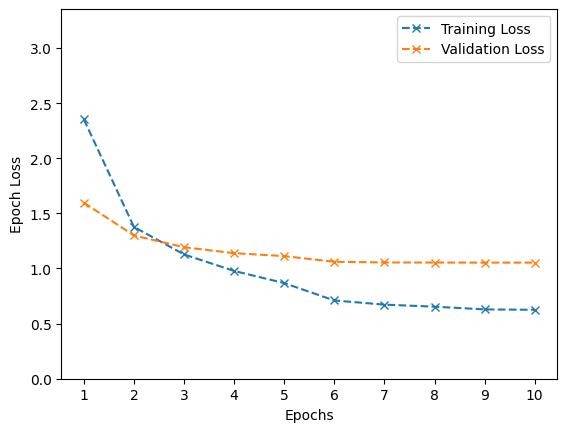

In [ ]:
# Mettez train_from_scratch à True pour entrainer un modèle depuis le début.
# Sinon, un modèle pré-entraîné sera chargé.
# Il est possible de mettre "epoch" à une valeur faible (par ex. 2)
# et de relancer cette cellule pour continuer d'entraîner le modèle
# (`train_model` ne réinitialise pas le modèle)

train_from_scratch = True

if train_from_scratch:
    checkpoint_path = os.path.join(model_dir, 'rnn.pt')
else:
    checkpoint_path = os.path.join(model_dir, 'pretrained-rnn.pt')

print('checkpoint path:', checkpoint_path)

if os.path.exists(checkpoint_path) and not train_from_scratch:
    rnn_model = torch.load(checkpoint_path)
else:
    train_model(train_iterator, [valid_iterator], rnn_model,
                epochs=10,
                checkpoint_path=checkpoint_path)

###Questions
1. Est-ce que la courbe d'apprentissage vous semble correcte ?
2. Sommes-nous dans une situation de surapprentissage ? Comment détecte-t-on une telle situation ?
3. Dans les scores d'apprentissage à chaque époque, voyez-vous apparaitre  `reducing learning rate of group 0 to 1.00...` ? Si oui, que cela signifie-t-il ?

In [ ]:
def show_attention(input_sentence, output_words, attentions):
    # Affiche la matrice d'attention de l'encodeur-décodeur
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [nmt_dataset.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ') +
                       [nmt_dataset.EOS_TOKEN])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def encode_as_batch(sentence, dictionary, source_lang, target_lang):
    # Crée un lot à partir d'une seule phrase
    sentence = sentence + ' ' + nmt_dataset.EOS_TOKEN
    tensor = dictionary.txt2vec(sentence).unsqueeze(0)

    return {
        'source': tensor,
        'source_len': torch.from_numpy(np.array([tensor.shape[-1]])),
        'source_lang': source_lang,
        'target_lang': target_lang
    }


def generate_sentence(model, sentence, dictionary, source_lang, target_lang, return_output=False):
    # Traduit une phrase à partir d'un modèle donné.
    print('Source:', sentence)
    sentence_tok = preprocess(sentence, is_source=True, source_lang=source_lang, target_lang=target_lang)
    print('Tokenized source:', sentence_tok)
    batch = encode_as_batch(sentence_tok, dictionary, source_lang, target_lang)
    prediction, attn_matrix, enc_self_attn = model.eval_step(batch)
    prediction = prediction[0]
    prediction_detok = postprocess(prediction)
    print('Prediction:', prediction)
    print('Detokenized prediction:', prediction_detok)


    results = {
        'source': sentence,
        'source_tokens': sentence_tok.split(' ') + ['<eos>'],
        'prediction_detok': prediction_detok,
        'prediction_tokens': prediction.split(' '),
    }

    if attn_matrix is not None:
        attn_matrix = attn_matrix[0].detach().cpu().numpy()
        results['attention_matrix'] = attn_matrix
        show_attention(sentence_tok, prediction, attn_matrix)

    if enc_self_attn is not None:
        results['encoder_self_attention_list'] = enc_self_attn

    if return_output:
        return results

def generate(sentence):
  generate_sentence(rnn_model, sentence, source_dict, source_lang, target_lang)


def generate_random():
    with open('data/webNLG2020.train_src.txt', "r") as file:
        content = file.readlines()
    import random
    i = random.randint(1, len(content))
    input = content[i]
    with open('data/webNLG2020.train_tgt.txt', "r") as file:
        content = file.readlines()
    ref = content[i]

    generate_sentence(rnn_model, input, source_dict, source_lang, target_lang)
    print("reference: " + ref)


#Évaluation du modèle


Le code ci-dessous calcule le score bleu du modèle sur le corpus de dev (validation). À quel point ce score vous informe-t-il de la qualité de la génération ?  

In [ ]:
print('BLEU:', rnn_model.translate(valid_iterator, postprocess).score)

BLEU: 20.95


Le code ci-dessous extrait au hasard des exemples du corpus d'apprentissage (`train`) et génère une sortie.
###Question
1. Est-ce que l'on peut s'attendre à des mots hors vocabulaire pour ce type d'exemple ?
2. Analysez quelques sorties. Gardez en tête que le modèle n'a pas été entrainé avec suffisamment de données. Est-ce que le lexique employé semble correct ? Pouvez-vous détecter des informations non générées ainsi que des informations non présentes dans la source (hallucinations) ?

In [ ]:
# Tire un exemple aléatoire de l'ensemble d'entraînement
generate_random()

Source: Albany,_Georgia | areaCode | 229 && Albany,_Georgia | elevationAboveTheSeaLevel | 62.0 && Albany,_Georgia | populationDensity | 535.0 (inhabitants per square kilometre) && Albany,_Georgia | isPartOf | United_States && Albany,_Georgia | areaTotal | 144.7 (square kilometres)

Tokenized source: albany,_georgia | areacode | 229 && albany,_georgia | elevationabovethesealevel | 62.0 && albany,_georgia | populationdensity | 535.0 (inhabitants per square kilometre) && albany,_georgia | ispartof | united_states && albany,_georgia | areatotal | 144.7 (square kilometres)

Prediction: albany is part of dougherty county in georgia , in the united states .
Detokenized prediction: albany is part of dougherty county in georgia , in the united states .
reference: Albany is located in Georgia , United States at 62.0 above sea level . The population density is 535 inhabitants per sq km within a total area of 144.7 sq km .



### Questions
1. Analysez les sorties pour les exemples choisis suivants.
2. Déduisez la capacité du modèle à générer à partir d'exemples qu'il n'a jamais vus.
3. Quelle semble être la capacité des modèles à traiter les nombres ?

1 triplet

In [ ]:
generate('Atlanta | isPartOf | Georgia_(U.S._state)')
#Atlanta is part of Georgia , US .

Source: Atlanta | isPartOf | Georgia_(U.S._state)
Tokenized source: atlanta | ispartof | georgia_(u.s._state)
Prediction: atlanta is part of the state of georgia in the united states .
Detokenized prediction: atlanta is part of the state of georgia in the united states .


In [ ]:
generate('Grenoble | capital | Alpes_(France)')
# reference: Grenoble is the capital of the Alpes , in France .

Source: Grenoble | capital | Alpes_(France)
Tokenized source: grenoble | capital | alpes_(france)
Prediction: the city of albany is part of benton county , oregon , in the united states .
Detokenized prediction: the city of albany is part of benton county , oregon , in the united states .


2 triplets

In [ ]:
generate('Albany,_Oregon | isPartOf | Oregon && Oregon | largestCity | Portland,_Oregon')
#Portland is the largest city in Oregon which also includes Albany .

Source: Albany,_Oregon | isPartOf | Oregon && Oregon | largestCity | Portland,_Oregon
Tokenized source: albany,_oregon | ispartof | oregon && oregon | largestcity | portland,_oregon
Prediction: albany is part of benton county , oregon , in the united states .
Detokenized prediction: albany is part of benton county , oregon , in the united states .


In [ ]:
generate('Grenoble | isPartOf | Auvergne-Rhône-Alpes && Grenoble | country | France' )

Source: Grenoble | isPartOf | Auvergne-Rhône-Alpes && Grenoble | country | France
Tokenized source: grenoble | ispartof | auvergne-rhône-alpes && grenoble | country | france
Prediction: the city of albany is part of benton county , oregon , in the united states .
Detokenized prediction: the city of albany is part of benton county , oregon , in the united states .


3 triplets

In [ ]:
generate('Grenoble | isPartOf | Auvergne-Rhône-Alpes && Grenoble | country | France && Auvergne-Rhône-Alpes | language | French_language ')

Source: Grenoble | isPartOf | Auvergne-Rhône-Alpes && Grenoble | country | France && Auvergne-Rhône-Alpes | language | French_language 
Tokenized source: grenoble | ispartof | auvergne-rhône-alpes && grenoble | country | france && auvergne-rhône-alpes | language | french_language 
Prediction: the city of albany is part of benton county , oregon , in the united states .
Detokenized prediction: the city of albany is part of benton county , oregon , in the united states .


In [ ]:
generate('Saint_Petersburg | foundingDate | 1703-05-27 && Olga_Bondareva | deathPlace | Saint_Petersburg && Saint_Petersburg | areaTotal | 1439.0')

# Saint Petersburg was founded on May 27, 1703 and has a total area of 1439.0, Olga Bondareva passed away at Saint Petersburg.
# Saint Petersburg, where Olga Bondareva died, was founded on the 27th of May, 1703 and has a total area of approximately 1439 km2.
# Saint Petersburg, where Olga Bondareva died, was founded on May 27, 1703 and consists of a total area of 1439.0 sq/km.

Source: Saint_Petersburg | foundingDate | 1703-05-27 && Olga_Bondareva | deathPlace | Saint_Petersburg && Saint_Petersburg | areaTotal | 1439.0
Tokenized source: saint_petersburg | foundingdate | 1703-05-27 && olga_bondareva | deathplace | saint_petersburg && saint_petersburg | areatotal | 1439.0
Prediction: the city of albany is part of benton county , oregon , in the united states .
Detokenized prediction: the city of albany is part of benton county , oregon , in the united states .


4 triplets

In [ ]:
generate('Antioch,_California | utcOffset | "-7" && Antioch,_California | populationTotal | 102372 && Antioch,_California | areaCode | 925 && Antioch,_California | areaTotal | 75.324 (square kilometres)')
#Antioch , California has a UTC offset of - 7 , the population is 102372 , the area code is 925 , and has a total area of 75.324 square km .

Source: Antioch,_California | utcOffset | "-7" && Antioch,_California | populationTotal | 102372 && Antioch,_California | areaCode | 925 && Antioch,_California | areaTotal | 75.324 (square kilometres)
Tokenized source: antioch,_california | utcoffset | "-7" && antioch,_california | populationtotal | 102372 && antioch,_california | areacode | 925 && antioch,_california | areatotal | 75.324 (square kilometres)
Prediction: antioch in california has a utc offset of -7 , and the area code 925 .
Detokenized prediction: antioch in california has a utc offset of -7 , and the area code 925 .


In [ ]:
generate('Trane | foundingDate | 1913-01-01 && Trane | location | Ireland && Trane | foundationPlace | La_Crosse,_Wisconsin && Trane | numberOfEmployees | 29000')
#Trane, which was founded on January 1st 1913 in La Crosse, Wisconsin, is based in Ireland. It has 29,000 employees.

Source: Trane | foundingDate | 1913-01-01 && Trane | location | Ireland && Trane | foundationPlace | La_Crosse,_Wisconsin && Trane | numberOfEmployees | 29000
Tokenized source: trane | foundingdate | 1913-01-01 && trane | location | ireland && trane | foundationplace | la_crosse,_wisconsin && trane | numberofemployees | 29000
Prediction: the city of albany is part of benton county , oregon , in the united states .
Detokenized prediction: the city of albany is part of benton county , oregon , in the united states .


# Extension du TP

###Questions
1. Ré-essayez l'apprentissage en incluant/enlevant la segmentation NPE (fonction `preprocess`) et concluez expérimentalement quant à son impact.
2. Ré-entraînez le modèle en incluant tous les exemples d'apprentissage (fonction `get_data`)
3. Ce modèle pourrait être étendu avec un mécanisme permettant de prendre en compte les tokens d'entrée à chaque décodage plutôt que de reposer uniquement sur le vecteur de contexte de l'encodeur. Quel est ce mécanisme ? Vous pouvez le mettre en place en allant regarder dans le code de définition de la partie décodeur du modèle.   

In [ ]:
# Applique la tokenization BPE à la chaîne d'entrée
def preprocess(line, is_source=True, source_lang=None, target_lang=None):
  # return bpe_model.segment(line.lower()) !!! decomment
  return line.lower()

# Instead of:
# rnn_decoder = nnet_models.RNN_Decoder(...)

# Use:
rnn_decoder = nnet_models.AttentionDecoder(
    output_size=len(target_dict),
    hidden_size=512,
    num_layers=1,
    dropout=0.2
)
